In [1]:
import nltk
import os
import pandas as pd

### setup ###
#### icnale ####

In [2]:
#read the files into pandas dataframe for better manipulation later on
ptj_path = 'ptj'
smk_path = 'smk'

ptj_data = []
smk_data = []

# Loop through all .txt files in the parttime job folder
for filename in os.listdir(ptj_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(ptj_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            ptj_data.append({
                "filename": filename,
                "text": text
            })
            
# Loop through all .txt files in the no smoking folder
for filename in os.listdir(smk_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(smk_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            smk_data.append({
                "filename": filename,
                "text": text
            })

ptj_df = pd.DataFrame(ptj_data)
smk_df = pd.DataFrame(smk_data)

In [3]:
smk_df.head()

,filename,text
0,WE_KOR_SMK0_260_B2_0.txt,﻿I agree with the statement that smoking shoul...
1,WE_KOR_SMK0_284_B2_0.txt,﻿I think that smoking should be completely pro...
2,WE_KOR_SMK0_285_B2_0.txt,﻿I believe that smoking should be completely b...
3,WE_KOR_SMK0_292_B2_0.txt,﻿I agree that smoking should be completely ban...
4,WE_KOR_SMK0_271_B2_0.txt,﻿I agree that smoking should be completely ban...


#### locness ####

In [4]:
import re

def extract_chunks_from_file(filepath):
    with open(filepath, 'r', encoding='latin-1') as file:
        content = file.read()

    # Split content into chunks on patterns like <section>
    pattern = r'(?=<[^<>]+>)'
    chunks = re.split(pattern, content)

    data = []
    for chunk in chunks:
        chunk = chunk.strip()
        if not chunk:
            continue
        match = re.match(r'<([^<>]+)>\s*(.*)', chunk, re.DOTALL)
        if match:
            tag, text = match.groups()
            data.append({'filename': os.path.basename(filepath), 'section': tag.strip(), 'content': text.strip()})

    return data

def process_folder(folder_path):
    all_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(folder_path, filename)
            file_chunks = extract_chunks_from_file(filepath)
            all_data.extend(file_chunks)

    df = pd.DataFrame(all_data)
    df.set_index(['filename', 'section'], inplace=True)
    return df

locness_path = 'locness'
locness_df = process_folder(locness_path)

In [5]:
locness_df = locness_df.iloc[:50]
locness_df.shape[0]

50

In [6]:
locness_df.head()

content
filename     section                                                            
alevels9.txt ICLE-ALEV-0001.9  As the technological advances made in science ...
             ICLE-ALEV-0002.9  How far and in what ways has the human brain b...
             ICLE-ALEV-0003.9  There has always been a wide range of reasons ...
             ICLE-ALEV-0004.9  There are several reasons why people in the UK...
             ICLE-ALEV-0005.9  People in the U.K. may refuse to eat beef due ...

### reference ###

In [7]:
#anaphoric reference
#may need hugging face model to do anaphoric reference
anaphoric_list = ['as stated previously', 'the aforementioned']

from nltk import word_tokenize, pos_tag, sent_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /Users/Catherine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Catherine/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/Catherine/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

At first I tried to use just ntlk to find references, but I realized that it was very hard to check for agreement and overlap with just the barebones tools. 

So I changed course and decided to try using spacy to help capture the nuance in references, more specifically anaphoric references. 

Spacy seems to do a much better job at pinpointing pairs that actually make sense. These new pairs seems to be far more likely to have agreement, and repeated pairs like 'it' and 'college' have significantly decreased in appearance.

In [8]:
#This function is no longer used for the final product
# Helper function
def find_references(text):
    anaphora = []
    sentences = sent_tokenize(text)
    
    for i, sent in enumerate(sentences):
        tokens = word_tokenize(sent)
        tagged = pos_tag(tokens)

        # Find potential antecedents: proper nouns or singular nouns (NNP, NN, etc.)
        antecedents = [word for word, tag in tagged if tag in ('NNP', 'NNPS', 'NN', 'NNS')]

        # Look in current and next sentence for pronouns (PRP)
        next_sent = sentences[i+1] if i+1 < len(sentences) else ''
        combined = sent + ' ' + next_sent
        combined_tokens = word_tokenize(combined)
        combined_tagged = pos_tag(combined_tokens)

        ref = [word for word, tag in combined_tagged if tag == 'PRP']

        if antecedents and ref:
            for ant in antecedents:
                for pro in ref:
                    anaphora.append((ant, pro))

    return anaphora

In [9]:
# Apply to dataframe
ptj_df['references'] = ptj_df['text'].apply(find_references)
smk_df['references'] = smk_df['text'].apply(find_references)
locness_df['references'] = locness_df['content'].apply(find_references)

In [10]:
# Output
ptj_df[['text', 'references']].head()

,text,references
0,﻿It is important for college student to have p...,"[(college, It), (college, it), (students, It),..."
1,﻿Most college students get a part time job eve...,"[(Needless, they), (Needless, themselves), (lo..."
2,﻿I believe that it is important for college st...,"[(﻿I, it), (college, it), (students, it), (job..."
3,﻿Many students are having part time jobs these...,"[(students, It), (part, It), (time, It), (jobs..."
4,﻿It is during your college years where you can...,"[(﻿It, you), (﻿It, I), (﻿It, them), (﻿It, you)..."


In [11]:
locness_df[['content', 'references']].head()

content  \
filename     section                                                               
alevels9.txt ICLE-ALEV-0001.9  As the technological advances made in science ...   
             ICLE-ALEV-0002.9  How far and in what ways has the human brain b...   
             ICLE-ALEV-0003.9  There has always been a wide range of reasons ...   
             ICLE-ALEV-0004.9  There are several reasons why people in the UK...   
             ICLE-ALEV-0005.9  People in the U.K. may refuse to eat beef due ...   

                                                                      references  
filename     section                                                              
alevels9.txt ICLE-ALEV-0001.9  [(advances, it), (science, it), (products, it)...  
             ICLE-ALEV-0002.9  [(ways, it), (brain, it), (redundant, it), (in...  
             ICLE-ALEV-0003.9  [(Cruelty, it), (animals, it), (people, it), (...  
             ICLE-ALEV-0004.9  [(cows, it), (feed, it), (sheep, it), (brains,...  
             ICLE-ALEV-0005.9  [(People, It), (U.K., It), (beef, It), (concer...

As I believe the spacy function is more accurate, I will be overriding the prior column with the new pairs found through spacy.

In [12]:
!pip3 install spacy
!python3 -m spacy download en_core_web_sm


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
import spacy

# Load English model
nlp = spacy.load("en_core_web_sm")

def find_references_spacy(text):
    """
    Identifies likely reference (anaphora) links in a text using spaCy.
    Looks for pronouns that are syntactically dependent on or near proper/common nouns.
    """

    doc = nlp(text)
    references = []

    for sent in doc.sents:
        pronouns = [token for token in sent if token.pos_ == "PRON" and token.dep_ != "poss"]
        candidates = [token for token in sent if token.pos_ in ("PROPN", "NOUN")]

        for pro in pronouns:
            # Look backward for potential antecedents (basic heuristic: proximity + sentence-level)
            for ant in reversed(candidates):
                # Ensure they are not the same word
                if ant.i < pro.i:
                    # Very basic gender/number compatibility (optional)
                    references.append((ant.text, pro.text))
                    break  # assume first likely match

    return references


In [14]:
# Apply to dataframe
ptj_df['references'] = ptj_df['text'].apply(find_references_spacy)
smk_df['references'] = smk_df['text'].apply(find_references_spacy)
locness_df['references'] = locness_df['content'].apply(find_references_spacy)

In [15]:
# Output
ptj_df[['text', 'references']].head()

,text,references
0,﻿It is important for college student to have p...,"[(student, themselves), (chance, them), (a'job..."
1,﻿Most college students get a part time job eve...,"[(living, themselves), (fee, they), (fee, I), ..."
2,﻿I believe that it is important for college st...,"[(﻿I, it), (Korea, there), (students, who), (s..."
3,﻿Many students are having part time jobs these...,"[(reason, they), (money, there), (things, they..."
4,﻿It is during your college years where you can...,"[(years, you), (life, I), (jobs, them), (colle..."


compute the number of reference pairs for L1 and L2 (these are now ones found through the function 'find_references_spacy')

In [16]:
locness_refs = locness_df['references'].apply(len).sum()
icnale_refs = smk_df['references'].apply(len).sum() + ptj_df['references'].apply(len).sum()

In [17]:
L1_cohesions = locness_refs
L2_cohesions = icnale_refs
print(f"{L1_cohesions} references in L1 writing, \n{L2_cohesions} references in L2 writing")

711 references in L1 writing, 
542 references in L2 writing


### conjunctions ###

In [18]:
# Define conjunctions to extract
conjunctions = r'\b(and|or|but|yet|so|then)\b'

# Function to extract conjunctions
def extract_conjunctions(text):
    return re.findall(conjunctions, text, flags=re.IGNORECASE)


In [19]:
locness_df['conjunctions'] = locness_df['content'].apply(extract_conjunctions)
ptj_df['conjunctions'] = ptj_df['text'].apply(extract_conjunctions)
smk_df['conjunctions'] = smk_df['text'].apply(extract_conjunctions)

In [20]:
smk_df['conjunctions'].head()

0                                 [and, and, and, and]
1    [and, but, and, So, and, and, and, So, So, but...
2             [and, and, and, and, and, but, but, and]
3              [but, and, and, and, and, But, and, So]
4    [But, And, and, and, And, and, And, and, and, ...
Name: conjunctions, dtype: object

In [21]:
locness_conj = locness_df['conjunctions'].apply(len).sum()
icnale_conj = smk_df['conjunctions'].apply(len).sum() + ptj_df['conjunctions'].apply(len).sum()

In [22]:
print(locness_conj, icnale_conj)

662 399


In [23]:
L1_cohesions += locness_conj
L2_cohesions += icnale_conj
print(f"{L1_cohesions} overall cohesion features in L1 writing, \n{L2_cohesions} overall cohesion features in L2 writing")

1373 overall cohesion features in L1 writing, 
941 overall cohesion features in L2 writing


### lexical cohesion ###

In [24]:
from nltk.corpus import wordnet as wn

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Catherine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
def get_wordnet_synonyms(word):
    """Return a set of synonyms for a given word from WordNet."""
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return synonyms

def extract_nearby_synonym_pairs(text, max_distance=1):
    """Find synonym pairs that occur within `max_distance` sentences."""
    sentences = sent_tokenize(text)
    synonym_pairs = []

    for i, sent in enumerate(sentences):
        words_i = word_tokenize(sent)
        words_i = [w.lower() for w in words_i if w.isalpha()]
        synonyms_i = {w: get_wordnet_synonyms(w) for w in words_i}

        # Compare with nearby sentences
        for j in range(i+1, min(i+1+max_distance, len(sentences))):
            words_j = word_tokenize(sentences[j])
            words_j = [w.lower() for w in words_j if w.isalpha()]
            for word1, syns1 in synonyms_i.items():
                for word2 in words_j:
                    if word2 in syns1 and word1 != word2:
                        synonym_pairs.append((word1, word2))

    return synonym_pairs


In [26]:
locness_df['synonyms'] = locness_df['content'].apply(lambda x: extract_nearby_synonym_pairs(x))
ptj_df['synonyms'] = ptj_df['text'].apply(lambda x: extract_nearby_synonym_pairs(x))
smk_df['synonyms'] = smk_df['text'].apply(lambda x: extract_nearby_synonym_pairs(x))

In [27]:
locness_syn = locness_df['synonyms'].apply(len).sum()
icnale_syn = smk_df['synonyms'].apply(len).sum() + ptj_df['synonyms'].apply(len).sum()

Like references, I was unhappy with the amount of duplicate and trivial pairs found through the original function. I found that too many 'light verbs' like 'have', 'be', and 'give' were picked up as lexical cohesion pairs when they don't really count. Below is an updated iteration that first takes out duplication and some not very adequate synonym pairs and also post-processes the 'light verbs' out. 

Again I will be overriding the prior columns for simplicity.

In [30]:
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/Catherine/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Catherine/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [31]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import string


lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """Map POS tag to first character for lemmatization."""
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN  # default to noun

def get_synonyms(word, pos):
    """Return a set of WordNet synonyms for a word and POS."""
    synonyms = set()
    for syn in wn.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            name = lemma.name().lower().replace("_", " ")
            if name != word:
                synonyms.add(name)
    return synonyms

def extract_lexical_cohesion_pairs(text, max_distance=1):
    """Find lexical cohesion pairs (synonyms) across nearby sentences."""
    sentences = sent_tokenize(text)
    cohesion_pairs = []

    # Preprocess all sentences: tokenize, POS tag, and lemmatize
    processed_sentences = []
    for sent in sentences:
        tokens = word_tokenize(sent)
        tagged = nltk.pos_tag(tokens)
        lemmatized = [
            (lemmatizer.lemmatize(w.lower(), get_wordnet_pos(pos)), get_wordnet_pos(pos))
            for w, pos in tagged
            if w.isalpha() and w.lower() not in string.punctuation
        ]
        processed_sentences.append(lemmatized)

    # Cache synonyms for unique words across the text
    synonym_cache = defaultdict(set)
    for sent in processed_sentences:
        for word, pos in sent:
            if word not in synonym_cache:
                synonym_cache[word] = get_synonyms(word, pos)

    # Compare across sentence pairs within the given distance
    for i in range(len(processed_sentences)):
        words_i = [w for w, _ in processed_sentences[i]]
        for j in range(i+1, min(i+1+max_distance, len(processed_sentences))):
            words_j = [w for w, _ in processed_sentences[j]]
            for w1 in words_i:
                for w2 in words_j:
                    if w2 in synonym_cache[w1] and w1 != w2:
                        cohesion_pairs.append((w1, w2))

    return cohesion_pairs


In [32]:
LIGHT_VERBS = {"do", "make", "have", "be", "get", "go", "put", "take", "give"}

def del_light_verbs(text):
    for i in range(len(text)):
        text[i] = [pair for pair in text[i] if pair[0] not in LIGHT_VERBS and pair[1] not in LIGHT_VERBS]
    return None

In [33]:
locness_df['synonyms'] = locness_df['content'].apply(extract_lexical_cohesion_pairs)
ptj_df['synonyms'] = ptj_df['text'].apply(extract_lexical_cohesion_pairs)
smk_df['synonyms'] = smk_df['text'].apply(extract_lexical_cohesion_pairs)

In [34]:
ptj_df['synonyms']

0     [(make, earn), (make, give), (make, have), (gi...
1     [(get, have), (get, make), (make, do), (live, ...
2     [(have, take), (take, have), (take, have), (ta...
3      [(one, i), (work, influence), (work, influence)]
4     [(experience, have), (have, get), (have, exper...
5     [(have, let), (have, make), (follow, be), (giv...
6     [(do, make), (make, have), (have, take), (have...
7     [(wage, pay), (see, hear), (run, work), (run, ...
8     [(live, be), (live, be), (one, i), (have, expe...
9     [(experience, know), (have, experience), (want...
10    [(have, experience), (have, get), (experience,...
11    [(i, one), (have, get), (have, experience), (g...
12    [(have, experience), (work, go), (have, experi...
13    [(have, experience), (aid, help), (get, have),...
14    [(take, learn), (take, make), (really, very), ...
15    [(have, get), (get, have), (get, have), (get, ...
16    [(be, cost), (be, cost), (have, take), (be, co...
17            [(about, some), (have, get), (only

In [35]:
del_light_verbs(locness_df['synonyms'])
del_light_verbs(ptj_df['synonyms'])
del_light_verbs(smk_df['synonyms'])

/var/folders/ql/480bqgd56wz4x3b25hcy0bhr0000gn/T/ipykernel_64872/543707655.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text[i] = [pair for pair in text[i] if pair[0] not in LIGHT_VERBS and pair[1] not in LIGHT_VERBS]
/var/folders/ql/480bqgd56wz4x3b25hcy0bhr0000gn/T/ipykernel_64872/543707655.py:5: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  text[i] = [pair for pair in text[i] if pair[0] not in LIGHT_VERBS and pair[1] not in LIGHT_VERBS]
/var/folders/ql/480bqgd56wz4x3b25hcy0bhr0000gn/T/ipykernel_64872/543707655.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

In [36]:
locness_syn = locness_df['synonyms'].apply(len).sum()
icnale_syn = smk_df['synonyms'].apply(len).sum() + ptj_df['synonyms'].apply(len).sum()

In [37]:
print(locness_syn, icnale_syn)

173 151


In [38]:
L1_cohesions += locness_syn
L2_cohesions += icnale_syn
print(f"{L1_cohesions} overall cohesion features in L1 writing, \n{L2_cohesions} overall cohesion features in L2 writing")

2248 overall cohesion features in L1 writing, 
1587 overall cohesion features in L2 writing


### Final calculations ###

In [62]:
locness_df['num_sent'] = locness_df['content'].apply(lambda x: len(sent_tokenize(x)))
ptj_df['num_sent'] = ptj_df['text'].apply(lambda x: len(sent_tokenize(x)))
smk_df['num_sent'] = smk_df['text'].apply(lambda x: len(sent_tokenize(x)))

In [63]:
L1_sentences = locness_df['num_sent'].sum()
L2_sentences = ptj_df['num_sent'].sum() + smk_df['num_sent'].sum()

In [64]:
from nltk import word_tokenize
locness_df['num_words'] = locness_df['content'].apply(lambda x: len(word_tokenize(x)))
ptj_df['num_words'] = ptj_df['text'].apply(lambda x: len(word_tokenize(x)))
smk_df['num_words'] = smk_df['text'].apply(lambda x: len(word_tokenize(x)))

In [65]:
L1_words = locness_df['num_words'].sum()
L2_words = ptj_df['num_words'].sum() + smk_df['num_words'].sum()

In [66]:
L1_density = L1_cohesions/L1_words
L2_density = L2_cohesions/L2_words

In [67]:
print(L1_density)

0.08444857158463975


In [68]:
print(L2_density)

0.08537252755843953


In [69]:
smk_df['synonyms'].head()

0    [(smoking, smoke), (smoking, smoke), (smoking,...
1    [(smoking, smoke), (country, area), (country, ...
2                                                   []
3                                      [(case, cause)]
4    [(smoke, smoking), (smoke, smoking), (smoking,...
Name: synonyms, dtype: object

In [32]:
!pip3 install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


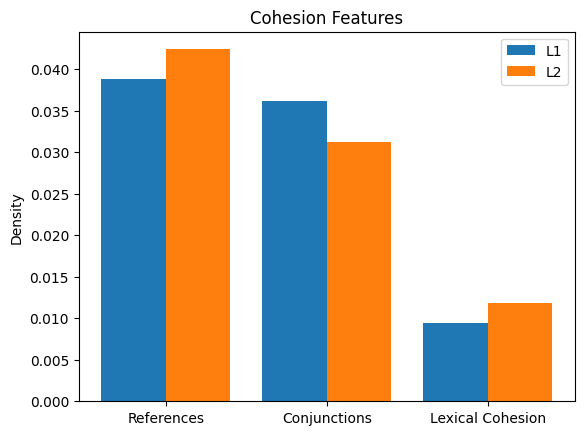

In [70]:
import numpy as np
import matplotlib.pyplot as plt

features = ['References', 'Conjunctions', 'Lexical Cohesion'] # categories
vals1, vals2 = [locness_refs/L1_words, locness_conj/L1_words, locness_syn/L1_words], [icnale_refs/L2_words, icnale_conj/L2_words, icnale_syn/L2_words]

# Bar width and x locations
w, x = 0.4, np.arange(len(features))

fig, ax = plt.subplots()
ax.bar(x - w/2, vals1, width=w, label='L1')
ax.bar(x + w/2, vals2, width=w, label='L2')

ax.set_xticks(x)
ax.set_xticklabels(features)
ax.set_ylabel('Density')
ax.set_title('Cohesion Features')
ax.legend()

plt.show()


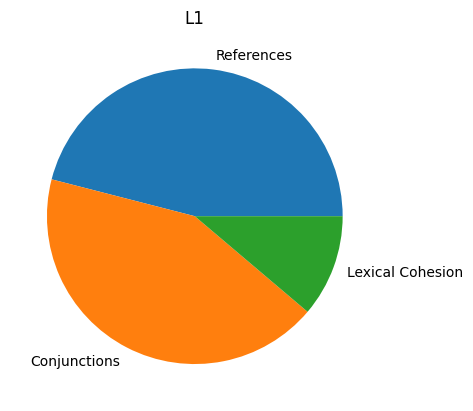

In [74]:
y = np.array([locness_refs, locness_conj, locness_syn])
mylabels = ["References", "Conjunctions", "Lexical Cohesion"]

plt.pie(y, labels = mylabels)
plt.title("L1")
plt.show() 

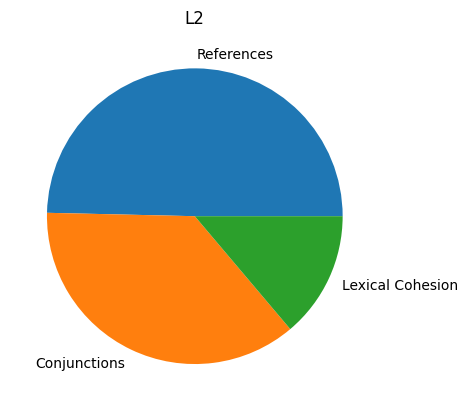

In [73]:
y = np.array([icnale_refs, icnale_conj, icnale_syn])
mylabels = ["References", "Conjunctions", "Lexical Cohesion"]

plt.pie(y, labels = mylabels)
plt.title("L2")
plt.show() 